# Capstone Project - The Battle of Neighborhoods (Week 1)

## 1. Introduction of the business problem

For restaurants business investors, there are some crucial factors determine whether you are finally successful or not. For example, if the restaurant sits on a place with abundant guest resource, or if nearby restaurants are already in good reputation can bring you high grade mature clients from the very beginning(restaurant clustering theory) and if your menu offers attractive food . 

So assuming here we have a new investor who is planning to open a new restaurant in New York(NY), one on-line intelligent estimation system is expected. This system simply takes some easy inputs such as the location of your targeted venue and some of the food you are planning to offer, a score will be predicted as an estimation for how successful your new business will be.

To implement this system, we will explore Foursquare geographic location data and pertinent social network data, to  train a machine learning model(classification), and finally to run a back-end prediction service. 

It will be a free on-line service opened to the audience who are planning to open a restaurant in a certain venue in New York city by clicking on the map and input some of your special food. The investor then get a score as predicted success indicator, and the investor can simply move mouse to change position or type in new food to get different scores continuously. Through trying this service, the investor tests different combinations of better address and more attractive foods for their final success. This prediction system is very useful to help investors because the risk of restaurant investment is greatly decreased from beginning.

## 2. Data explaration 

To train the model, you will see how we step by step explore Foursquare data to construct pertinent information as reasonable feature dataset.

### 2.1 Explore the New York neighborhood location data

To get location data, first we believe a good restaurant must own plenty of client source, i.e it can't be too far from Neighborhood where people clustered. So we uploaded total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood.

In [59]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium # map rendering library

from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [25]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [26]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']

    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]

    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.shape    

(306, 4)

In [27]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### 2.2 Explore the New York restaurants data
Now that we have all the neighborhoods listed, next step we will start from here, to get all the restaurants from New York as training data. These restaurants are representative, because they are close to resident people, in other words, they are close to potential clients.

In [28]:
column_names = ['v_id', 'v_name', 'v_dist', 'v_cat']
df1 = pd.DataFrame(columns=column_names)
df1.set_index('v_id')
df1.index.name = 'v_id'

df1 will be used to host the coming restaurant data. Through Foursquare *"search"* API we will first get all nearby restaurants for each of the above neighborhoods, to construct a full data list of all restaurant sit near those 306 New York neighborhoods.

In [29]:
CLIENT_ID = 'BXAL1QB3NPZEI2C1G00AN1B1LMIBEO1GZBD2OHDNKGRB0S4Z' # your Foursquare ID
CLIENT_SECRET = '4PG31ZMDFCOMG0LUPFHRJFOI2S1GHYTS1TOZU5EGJR0AK2E4' # your Foursquare Secret
VERSION = '20190205' # Foursquare API version
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

for i in range(len(neighborhoods)):
    neighborhood_latitude   = neighborhoods.loc[i,"Latitude"]
    neighborhood_longitude  = neighborhoods.loc[i,"Longitude"]
    neighborhood_name       = neighborhoods.loc[i,"Neighborhood"]
    neighborhood_borough    = neighborhoods.loc[i,"Borough"]
#     url = 'https://api.foursquare.com/v2/venues/search?&query=Restaurant,Coffee&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#         CLIENT_ID,
#         CLIENT_SECRET,
#         VERSION,
#         neighborhood_latitude,
#         neighborhood_longitude,
#         radius,
#         LIMIT)
#     results = requests.get(url).json()
#     with open("rstlist_{}.json".format(i), "w") as f:
#         json.dump(results, f)

# Don't uncomment the above code to execute because I'm registered Foursquare free developer, have only limited
# API access everyday. So I have stored local file.

    with open("rstlist_{}.json".format(i),'r') as load_f:
        results = json.load(load_f)
# transform the ID list json dict into a DF
    for v in results['response']['venues']:
        v_id=v.get("id")
        v_name=v.get("name")
        v_dist=v.get("location")["distance"]
        v_cat=None
        if not(v.get("categories")):continue
        for ca in v.get("categories"):
            if ca.get("primary"):v_cat=ca.get("name")
        try:
            df1=df1.append({'v_id': v_id,
                        'v_name': v_name,
                        'v_dist': v_dist,
                        'v_cat':v_cat
                       },
                      ignore_index=True)
        except:pass
    df1.to_csv('rest.csv')

In [30]:
  df1.shape

(9389, 4)

In [31]:
df1.head(5)

,v_id,v_name,v_dist,v_cat
0,4db03c875da32cf2df4509f4,Big Daddy's Caribbean Taste Restaurant,1008,Caribbean Restaurant
1,4c66e0068e9120a15929d964,Kaieteur Restaurant & Bakery,1011,Caribbean Restaurant
2,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,479,Caribbean Restaurant
3,4be5f0eacf200f47d1fa133c,McDonald's,904,Fast Food Restaurant
4,4c994113a004a1cdc3393e6e,Bay 241 Restaurant & Lounge,792,Caribbean Restaurant


We have stored the basic restaurant information into a csv file as local file, the listed information include:
* v_id: the venue id of the restaurant, we will then use this ID to approach more data around the restaurant
* v_name: the name of the restaurant
* c_dist: the distance from  restaurant to related neighborhood
* v_cat: the restaurant's major category

Remember each restaurant may be close to multiple neighborhoods, we need to merge them.  The next step we will add more advanced data to extend the restaurant data with more features and meanwhile remove duplication.

a reminder here: the dumped csv file above embedded some encoding bugs which cause Python decode exception error, so a special data washing is done to clean those dirty data( here manually). We then change the csv file name to "ny_restaurant", hence after we will use this clean data file. 

### 2.3 Explore advanced restaurants data to construct full feature 


__First, we come up with two new numerical features:__ 
* The average distance from one restaurant to all its nearby neighborhoods, 
* How many neighborhoods sit around a certain restaurant

In [32]:
# we have done getting a full list from NY neighborhood list
df2=pd.read_csv('ny_restaurant.csv')
#get how many neighborhoods this restaurant close to
nc=df2.groupby("v_id")["v_name"].count()#

#get how far the restaurant avg distace to all its neighborhoods
nda=df2.groupby("v_id")["v_dist"].mean()

df2.drop(["v_dist"],inplace=True,axis=1)
df2.set_index("v_id", drop=True, inplace=True)
df2=df2[~df2.index.duplicated(keep='last')]
df2.reindex()
df2["avg_dist_2_neighborhood"] = nda
df2["cnt_near_neighborhood"] = nc
df2["restaurant_id"]=df2.index

df2.index = range(len(df2))
df2.to_csv("rest_features.csv",index=False)
df2.shape

(5290, 5)

In [33]:
df2.head(2)

,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id
0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392
1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c


Form above data, you can see two new columns named __"avg_dist_2_neighborhood"__, and __"cnt_near_neighborhood"__. The useless column "v_dist" has been dropped off, and duplicated restaurants are also grouped in a single line in the dataframe. 

Ok, we move ahead to __add more features__ as:
* Latitude of the restaurant
* Longitude of the restaurant
* Average rating of clustered restaurants where this restaurant is the centroid
* How many recommended popular venues nearby this restaurant 
* The label(or the true target of regression) of the restaurant
* The menu items(food) offered from this restaurant

PS. don't uncomment following code, which will kill all my daily quota of Foursquare API. I will read the feature sample csv back in next cell


In [34]:
# Don't be surprised if you see I store csv and then load it back, becasue I have only free developer access to
# Foursquare, I have to have some intermid file to save my daily API visit quota. 


# df2=pd.read_csv("rest_features.csv")
# we will add more features to the dataframe
# df2["lat"]=None  # Latitude of the restaurant
# df2["lng"]=None  # Longitude of the restaurant
# df2["avg_rate"]=None # average rating of clustered restraurants where this restaurant is the centroid
# df2["nearby_rec"]=None  #how many recomended popular venus nearby this restaurant 
# df2["rating"]=None      # this is the label(or the true target of regression) of the restaurant
# df2["menu"]=None        # the menu items(food) offerred from this restaurant

# for i in range(len(df2)):
#     rid= df2.iloc[i]["restaurant_id"]
#     rname=df2.iloc[i]["v_name"]
#     url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
#         rid,
#         CLIENT_ID,
#         CLIENT_SECRET,
#         VERSION)
    # result= requests.get(url).json()    #
    # with open("venues_{}.json".format(i), "w") as f:
    #             json.dump(result, f)
#     try:
#         with open("venues_{}.json".format(i),'r') as load_f: result = json.load(load_f)
#     except:
#        break
        # continue
    # 2.0 get restaurant detail info
#     v_ll=[result['response']['venue']["location"]["lat"],result['response']['venue']["location"]["lng"]]
#     v_rating=result['response']['venue'].get('rating')
#     df2.loc[i,  "lat"] = v_ll[0]
#     df2.loc[i, "lng"]  = v_ll[1]
#     df2.loc[i, "rating"] = v_rating
 # 2.1 now let's get the restaurant menu
#     hasmenu=result['response']['venue'].get('hasMenu')
#     v_menu=[]
#     if not(hasmenu):
#         pass
#     else:
#         # url = 'https://api.foursquare.com/v2/venues/{}/menu?client_id={}&client_secret={}&v={}'.format(
#         #     rid,
#         #     CLIENT_ID,
#         #     CLIENT_SECRET,
#         #     VERSION)
#         # menus = requests.get(url).json()
#         # with open("menu_{}.json".format(i), "w") as f:
#         #     json.dump(menus, f)
#         try:
#             with open("menu_{}.json".format(i), "r") as mf: menus = json.load(mf)
#             mc = menus['response']['menu']['menus']['count']
#             if mc!=0:
#                 v_menu=get_menu_item(menus['response']['menu']['menus']["items"])
#         except:pass
#     df2.loc[i,"menu"] = "|".join(v_menu)

#     # 2.2 to get how many hot spot nearby the restaurant(popular venues)
#     url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&\
#           query=food, drinks, coffee, shops, arts, outdoors, sights, trending'.format(
#         CLIENT_ID,
#         CLIENT_SECRET,
#         VERSION,
#         v_ll[0],
#         v_ll[1],
#         500,
#         10)
#     recommends = requests.get(url).json()
#     venues = recommends['response']['groups'][0]['items']
#     v_count_n = len(venues)
#     print(v_count_n,"recommends found")
#     df2.loc[i,"nearby_rec"]=v_count_n
#     print(df2.loc[i])

#     v_nearby_rt = 0.0
#     if v_count_n>0:
#         nearby_venues = json_normalize(venues)  # flatten JSON into dataframe
#         filtered_columns = ['venue.id','venue.name', 'venue.categories']
#         nearby_venues = nearby_venues.loc[:, filtered_columns]
#         nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
#         #to count the average rating near by this rest
#         nb=0
#         for j in range(v_count_n):
#             print(nearby_venues.loc[j])
#             r_id = nearby_venues.loc[j,"id"]
#             url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
#                 r_id,
#                 CLIENT_ID,
#                 CLIENT_SECRET,
#                 VERSION)
#             rst= requests.get(url).json()
#             if not (rst): continue
#             try:
#                 rating = rst['response']['venue']['rating']
#                 if not (rating): rating=0
#                 else:nb+=1
#             except:
#                 rating=0
#             v_nearby_rt=v_nearby_rt+float(rating)
#         if not(nb):v_nearby_rt=0
#         else: v_nearby_rt=v_nearby_rt/nb
#     df2.loc[i,"avg_rate"] = v_nearby_rt
#     df2.to_csv("restaurant_data.csv",index=False)

# df2=pd.read_csv("restaurant_data.csv") # here we load part of the data as sample to have a look
# df2.dropna(subset=["rating"],inplace=True)# remove dirty data withpoupt label    
# df2["avg_rate"]=df2["rating"]+np.random.uniform(-2,2,size=len(df2))#have no premuim access,have to make this
# df2.to_csv("NY_restaurant_data.csv")

df2=pd.read_csv("NY_restaurant_data.csv") # here we load part of the data as sample to have a look
df2.shape    

(119, 12)

In [36]:
df2.head(2)

,Unnamed: 0,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,menu
0,0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,4.530947,11.0,6.5,NaN
1,1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.401281,11.0,6.5,Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...


We got all the information about the restaurant, almost ready to fit for the machine learning models, let's define a dictionary:

|Attribute Name|Data description |Data Type|Potential Contribution|
|:-|-|-|-|
|v_name|Restaurant name|String|n/a|
|v_cat|Category|Foursquare Category|certain Category maybe special popular, more easily catch eyes 
|avg_dist_2_neighborhood|Average distance from this restaurant  to all its nearby neighborhoods|float|the lower means distance closer to potential clients|
|cnt_near_neighborhood|how many nearby neighborhoods are close to this restaurant , for example with 1 km|int|the more means more potential clients |
|restaurant_id|Venue ID |Foursquare ID |n/a
|lat|latitude|float|n/a|
|lng|longitude|float|n/a|
|avg_rate|Average rating  of nearby popular sites(such as food, drinks, coffee, shops, arts, outdoors,etc.) |float|the higher, the more possibility for stable client source|
|nearby_rec|the total number of popular sites recommended from Foursquare which centriod by the restaurant |int|the higher, the more possibility for stable client source|
|menu|special food offered|list of food items|will do text clustering first before used for classification model|
|rating|the restaurant rating( how good the restaurant is)|float/classification|the label or target value(y)|


Notice: additional action needed for the the *"menu"* attribute as can't use it in classification model directly. I need to vectorize it and cluster the menus to categorize them. This part will be introduced in the *Text Clustering* model in the next segment.

## 3. Methdologies

For this scenario, the score prediction created from the input information turns out to be a classical problem of *"regression"*. Looking on the data set we got in above segment, obviously the *"Rating"* attribute is the target value (label). That means, the predicted value will be your potential "rating" base on the fact that you will run your new restaurant on the location you specified and on the foods you are going to offer.  

### 3.1 regression or classification? 

First I need to make a decision, shall I make the model to give a prediction as simply “bad or good” classification? Or make a regression to predict the expected “rating” as a float value?
I will have a look on the rating column by invoking pandas.DataFrame.describe() on sampling data:


In [37]:
df2[["rating"]].describe()

,rating
count,119.000000
mean,7.122689
std,0.926030
min,5.200000
25%,6.450000
50%,7.100000
75%,7.750000
max,9.100000


Looks like the rating value is high precision float and the std deviation is not significant.  That means, it needs relative more training data if adopting a regression prediction model which it very hard for my free developer Foursquare account.  Thus I decided to simplify  the problem by turning it to a binary classification. In that way, I need to label the restaurant data set by this rule: take the 75% value 7.75 as a threshold, if rating larger than 7.75, then label it as “Good”(1); or else label it as  “not good”(0).

In [38]:
df2["label"] = df2["rating"].apply(lambda x: "1" if x>=7.75 else "0")

In [39]:
df2.head(4)

,Unnamed: 0,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,menu,label
0,0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,4.530947,11.0,6.5,NaN,0
1,1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.401281,11.0,6.5,Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...,0
2,5,241 St Cafe & Restaurant,American Restaurant,1019.0,1,4c010e75cf3aa593825eccb0,40.903573,-73.850228,7.411729,15.0,6.6,NaN,0
3,8,Ripe Kitchen & Bar,Caribbean Restaurant,798.0,1,4d375ce799fe8eec99fd2355,40.898152,-73.838875,8.553371,4.0,8.7,Cuban Plantain Boat|Jerk Chicken Quesadilla|St...,1


### 3.2 Transform text attribute by leveraging clustering algorithm

Moving forward, the *menu* attribute. My gut feeling, the restaurant's menu definitely would influence the rating. But how? It's hard to use it on classification model directly, so we need to vectorize it. Text clustering is one possible way allocate the menu content into a certain category per its similarity to other menus, so restaurants with similar menu may compete on the same court, thus they have more chances to have similar rating.  

In [40]:
import nltk
from numpy import array
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.externals import joblib
from sklearn.feature_extraction.text import  TfidfVectorizer
from nltk.corpus import stopwords
import string
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Before clustering the menus, let's have quick look on the menu data: 

In [41]:
df2.fillna("NoneUpload", inplace=True)
menus=df2["menu"]
menus.head(3)

0                                           NoneUpload
1    Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...
2                                           NoneUpload
Name: menu, dtype: object

First I need to clean the messy strings by:1)remove punctuations 2) remove  stop words 3) tokenize it and at last  make tokenize the string into "words".  These are typical NLP steps to clean up the text data, so I leveraged NLTK to do some of the data preprocessing.

In [42]:
swords = stopwords.words('english')
swords.append("")
swords.extend(list(string.ascii_lowercase))

In [43]:
def clean_text(text): # seperrate a string into word list, clean useless things
    lst=[]
    lx = text.lower()
    lx = re.sub(r'[^\w\s]',' ',lx)
    lx = re.sub(r'[\d]',' ',lx)
    lst = lx.split(" ")
    lx=lx.strip()
    lst = [word for word in lst if word not in set(swords)]
    return lst
   

In [44]:
menus=menus.apply(lambda x: " ".join(clean_text(x)))
sentences=menus.values

There are many ways to turn text data to digital array, here I selected TF-IDF

In [45]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=clean_text)
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

In [46]:
# from sklearn import metrics
# scores = []
# for k in range(2, 10):
#     labels = KMeans(n_clusters=k,max_iter=300, n_init=40,init='k-means++',n_jobs=-1).fit(tfidf_matrix).labels_
#     score = metrics.silhouette_score(tfidf_matrix, labels)
#     scores.append(score)
# print(scores)
# we shall get K=8

Then I invoke sklearn Kmeans lib to group up menus in to clusters 

In [47]:
num_clusters = 8
km_cluster = KMeans(n_clusters=num_clusters, max_iter=300, n_init=40, 
                    init='k-means++',n_jobs=-1)
result = km_cluster.fit_predict(tfidf_matrix) 
print("Clustering result:", result)

Clustering result: [1 6 1 5 1 1 2 5 1 5 1 2 4 1 2 1 1 1 1 1 1 1 1 2 1 1 3 3 3 1 3 1 3 1 5 1 4
 1 1 1 1 2 1 1 1 1 7 1 1 1 0 1 1 6 7 1 1 1 0 1 4 1 1 7 1 1 1 4 5 1 7 1 1 6
 1 5 1 2 6 1 5 2 5 4 5 1 4 1 1 1 1 4 1 4 1 2 5 1 1 1 5 0 3 4 1 1 1 1 2 1 1
 2 5 7 1 3 5 0 5]


Here I got the group of each menu, then will add this new attribute upon the feature dataframe.

In [48]:
df2["menu_group"]= result

In [95]:
df2.head(3)

,Unnamed: 0,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,menu,label,menu_group
0,0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,4.530947,11.0,6.5,NoneUpload,0,1
1,1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.401281,11.0,6.5,Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...,0,6
2,5,241 St Cafe & Restaurant,American Restaurant,1019.0,1,4c010e75cf3aa593825eccb0,40.903573,-73.850228,7.411729,15.0,6.6,NoneUpload,0,1


Now, we finally have the matrix who will be used to train machiane learning models!

In [50]:
df=df2[["v_cat","avg_dist_2_neighborhood","cnt_near_neighborhood","avg_rate","menu_group","label"]]

In [51]:
df.head(3)

,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,avg_rate,menu_group,label
0,Caribbean Restaurant,479.0,1,4.530947,1,0
1,Fast Food Restaurant,904.0,1,7.401281,6,0
2,American Restaurant,1019.0,1,7.411729,1,0


In [52]:
df.shape

(119, 6)

### 3.3 Transform dummy variables to one-hot encoded values

The last step is to working on the dummy variable(menu group and category). I will use the panda's method 'get_dummies' to assign numerical values to them.

In [53]:
dummy_variable_1 = pd.get_dummies(df["v_cat"])
dummy_variable_2 = pd.get_dummies(df["menu_group"])

In [54]:
df = pd.concat([df, dummy_variable_1], axis=1)
df.drop("v_cat", axis = 1, inplace=True)

In [55]:
df = pd.concat([df, dummy_variable_2], axis=1)
df.drop("menu_group", axis = 1, inplace=True)

In [56]:
df.head(3)

,avg_dist_2_neighborhood,cnt_near_neighborhood,avg_rate,label,African Restaurant,American Restaurant,Asian Restaurant,Bakery,Bar,Breakfast Spot,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Deli / Bodega,Diner,Fast Food Restaurant,Gourmet Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kitchen Supply Store,Latin American Restaurant,Mexican Restaurant,Other Nightlife,Paella Restaurant,Pizza Place,Pub,Restaurant,Sandwich Place,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,0,1,2,3,4,5,6,7
0,479.0,1,4.530947,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,904.0,1,7.401281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1019.0,1,7.411729,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### 3.4 Classification model

The classification models was much more straightforward, with the location and food input features, I need to predict whether these choices , combine together, will bring up one success(1) or failed(0) business.
Here I have all the data for model training, I will divide them into training set and validation set:

In [57]:
y=  np.asarray(df["label"].astype("int"))
X=  np.asarray(df.drop("label", axis=1))

In [80]:
# As I don't have much data as Foursquare access limittation, I would rather pu more% for traning
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (95, 42) (95,)
Test set: (24, 42) (24,)


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.1, solver='liblinear',class_weight={1:0.65,0:0.35}).fit(X_train,y_train)
LR

LogisticRegression(C=0.1, class_weight={1: 0.65, 0: 0.35}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [87]:
yhat = LR.predict(X_test)
yhat

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0])

Lets try jaccard index for accuracy evaluation

In [88]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7083333333333334

### 3.5 Evaluation

Now , from a comprehensive angle, look at accuracy of classifier through confusion matrix.

In [92]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 3  5]
 [ 2 14]]


In [93]:
# Compute confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[ 3  5]
 [ 2 14]]


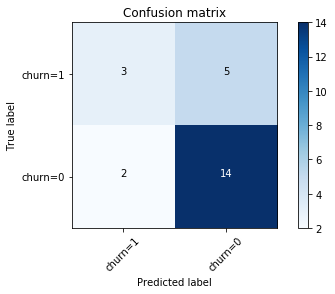

In [94]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

Theis classifier correctly predicted 14 of 16 as 0, so, it has done a good job in predicting the higher risk of bad rating in future. Meanwhile 5 of good rating prediction inccorectly to risky, this is bit high. Anyway, think nowthat avoiding risk is our goal, it is accceptable. 